In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time as ti
from google.colab import drive
%matplotlib inline

In [2]:
drive.mount('/content/gdrive')
!cd '/content/gdrive/My Drive/'


Mounted at /content/gdrive


# DATA Preparation

In [3]:
# Read the data From Google Drive
df = pd.read_csv("gdrive/My Drive/GCNIDS_Improvement/Mixed_dataset.csv")


In [4]:
"""values = df.values
groups = [1,2,3,4,5,6,7,8,9,10,11]
i = 1
plt.figure(figsize=(20,50))
for group in groups:
 plt.subplot(len(groups), 1, i)
 plt.plot(values[:, group])
 plt.title(df.columns[group], y=1, loc='right')
 i += 1
plt.show()"""

"values = df.values\ngroups = [1,2,3,4,5,6,7,8,9,10,11]\ni = 1\nplt.figure(figsize=(20,50))\nfor group in groups:\n plt.subplot(len(groups), 1, i)\n plt.plot(values[:, group])\n plt.title(df.columns[group], y=1, loc='right')\n i += 1\nplt.show()"

In [5]:
df.describe()

,Unnamed: 0.1,Unnamed: 0,CAN_ID,Data byte,data_1,data_2,data_3,data_4,data_5,data_6,data_7,data_8,attack_flag
count,800000.000000,8.000000e+05,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000
mean,399999.500000,1.499768e+06,697.651965,7.941269,57.294496,45.755469,40.993399,79.070042,51.635154,60.214489,26.524514,54.292584,0.434384
std,230940.252013,2.886955e+05,409.232029,0.567397,88.935731,55.120122,59.286051,102.920105,73.079311,76.994789,57.904071,81.019469,1.048479
min,0.000000,1.000000e+06,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,199999.750000,1.249284e+06,339.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,399999.500000,1.500045e+06,704.000000,8.000000,8.000000,32.000000,0.000000,20.000000,17.000000,32.000000,0.000000,0.000000,0.000000
75%,599999.250000,1.749335e+06,1072.000000,8.000000,69.000000,69.000000,96.000000,138.000000,107.000000,127.000000,10.000000,109.000000,0.000000
max,799999.000000,1.999998e+06,2047.000000,8.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,4.000000


In [6]:
from pandas import DataFrame
from pandas import concat
# Function for making time_series data
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 """
 Frame a time series as a supervised learning dataset.
 Arguments:
 data: Sequence of observations as a list or NumPy array.
 n_in: Number of lag observations as input (X).
 n_out: Number of observations as output (y).
 dropnan: Boolean whether or not to drop rows with NaN values.
 Returns:
 Pandas DataFrame of series framed for supervised learning.
 """
 n_vars = 1 if type(data) is list else data.shape[1]
 df = DataFrame(data)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
 # put it all together
 agg = concat(cols, axis=1)
 agg.columns = names
 # drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg

In [7]:
values = df.values
data = series_to_supervised(values,2,1)
print (data.head())

   var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  var5(t-2)  var6(t-2)  \
2        0.0  1356502.0      809.0        8.0      134.0      188.0   
3        1.0  1631087.0     1088.0        8.0      255.0        0.0   
4        2.0  1988876.0     1087.0        8.0        0.0       64.0   
5        3.0  1976387.0      880.0        8.0        0.0       32.0   
6        4.0  1741632.0     1264.0        8.0        0.0        0.0   

   var7(t-2)  var8(t-2)  var9(t-2)  var10(t-2)  ...  var4(t)  var5(t)  \
2      127.0       20.0       17.0        32.0  ...        8        0   
3        0.0        0.0      255.0       172.0  ...        8        0   
4       96.0      255.0      126.0       212.0  ...        8        0   
5        0.0        0.0        0.0         0.0  ...        8        0   
6        0.0      128.0        0.0       104.0  ...        8        5   

   var6(t)  var7(t)  var8(t)  var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  
2       64       96      255      126       212       

In [8]:
print (data.columns[[0,1,12,13,14,25,26,27,38]])


Index(['var1(t-2)', 'var2(t-2)', 'var13(t-2)', 'var1(t-1)', 'var2(t-1)',
       'var13(t-1)', 'var1(t)', 'var2(t)', 'var13(t)'],
      dtype='object')


In [9]:
# Cleaning data
data.drop(data.columns[[0,1,12,13,14,25,26,27]], axis=1, inplace=True)
print (data.head())
print (data.tail())

   var3(t-2)  var4(t-2)  var5(t-2)  var6(t-2)  var7(t-2)  var8(t-2)  \
2      809.0        8.0      134.0      188.0      127.0       20.0   
3     1088.0        8.0      255.0        0.0        0.0        0.0   
4     1087.0        8.0        0.0       64.0       96.0      255.0   
5      880.0        8.0        0.0       32.0        0.0        0.0   
6     1264.0        8.0        0.0        0.0        0.0      128.0   

   var9(t-2)  var10(t-2)  var11(t-2)  var12(t-2)  ...  var4(t)  var5(t)  \
2       17.0        32.0         0.0        20.0  ...        8        0   
3      255.0       172.0         8.0         0.0  ...        8        0   
4      126.0       212.0         8.0         0.0  ...        8        0   
5        0.0         0.0         0.0         0.0  ...        8        0   
6        0.0       104.0       209.0        19.0  ...        8        5   

   var6(t)  var7(t)  var8(t)  var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  
2       64       96      255      126     

In [10]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

values = data.values

# Splitting the data into train, val, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(values[:,:-1], values[:,-1], test_size=0.6, shuffle=False)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Reshape the data
X_train = X_train.reshape(X_train.shape[0], 3, 10)
X_test = X_test.reshape(X_test.shape[0], 3, 10)
X_val = X_val.reshape(X_val.shape[0], 3, 10)

# Display tensor shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")



X_train shape: (319999, 3, 10), y_train shape: (319999,)
X_test shape: (239999, 3, 10), y_test shape: (239999,)
X_val shape: (240000, 3, 10), y_val shape: (240000,)


# CNN model


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Generating random data for demonstration purposes
samples = X_train.shape[0]  # Number of samples
time_steps = X_train.shape[1]  # Time steps (or sequence length)
features = X_train.shape[2]  # Number of features

# Defining the model
model = Sequential()

# Convolutional layers
model.add(Conv1D(32, kernel_size=2, activation='relu', input_shape=(time_steps, features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=1, activation='relu'))
model.add(MaxPooling1D(pool_size=1))

# Flatten the output
model.add(Flatten())

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))  # Binary classification, so use sigmoid activation

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary to see the architecture and parameter count
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 2, 32)             672       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 1, 32)             0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 64)             2112      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [ ]:
# Display tensor shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (319999, 3, 10), y_train shape: (319999,)
X_test shape: (239999, 3, 10), y_test shape: (239999,)
X_val shape: (240000, 3, 10), y_val shape: (240000,)


In [ ]:
# Train the model
history_cnn = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/50
5000/5000 [==============================] - 21s 4ms/step - loss: 0.5313 - accuracy: 0.9268 - val_loss: 0.0983 - val_accuracy: 0.9715
Epoch 2/50
5000/5000 [==============================] - 28s 6ms/step - loss: 0.0733 - accuracy: 0.9778 - val_loss: 0.0460 - val_accuracy: 0.9863
Epoch 3/50
5000/5000 [==============================] - 25s 5ms/step - loss: 0.0466 - accuracy: 0.9856 - val_loss: 0.0414 - val_accuracy: 0.9882
Epoch 4/50
5000/5000 [==============================] - 23s 5ms/step - loss: 0.0360 - accuracy: 0.9886 - val_loss: 0.0544 - val_accuracy: 0.9835
Epoch 5/50
5000/5000 [==============================] - 25s 5ms/step - loss: 0.0325 - accuracy: 0.9895 - val_loss: 0.0263 - val_accuracy: 0.9915
Epoch 6/50
5000/5000 [==============================] - 21s 4ms/step - loss: 0.0296 - accuracy: 0.9901 - val_loss: 0.0365 - val_accuracy: 0.9882
Epoch 7/50
5000/5000 [==============================] - 24s 5ms/step - loss: 0.0284 - accuracy: 0.9905 - val_loss: 0.0278 - val_ac

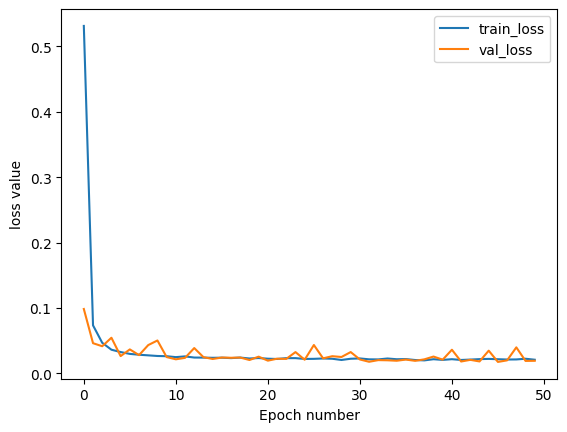

In [ ]:
# plot history
fig,ax = plt.subplots()
ax.plot(history_cnn.history['loss'], label='train_loss')
ax.plot(history_cnn.history['val_loss'], label='val_loss')
ax.set_xlabel('Epoch number')
ax.set_ylabel('loss value')
ax.legend()
plt.show()

In [ ]:
cnn_model = model
cnn_model.save("gdrive/My Drive/GCNIDS_Improvement/CNN_model(1).h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
from tensorflow.keras.models import load_model

# Load the saved model
cnn_model = load_model("gdrive/My Drive/GCNIDS_Improvement/CNN_model.h5")

In [ ]:
predicted_classe = cnn_model.predict(X_test)
predicted_classes = np.argmax(predicted_classe, axis=1)
#predictions = cnn_model.predict(X_test)
# Assuming 'model' is your trained model for binary classification
#threshold = 0.5  # Adjust the threshold as needed
#predicted_classes = (predictions > threshold).astype(int)


7500/7500 [==============================] - 16s 2ms/step


In [ ]:
predicted_classes[:100]

array([0, 4, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4,
       0, 2, 1, 4, 0, 0, 0, 0, 0, 1, 0, 0])

In [ ]:
y_test[:100]

array([0., 4., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 4., 0., 2., 1., 4., 0., 0., 0., 0., 0., 1., 0., 0.])

In [ ]:
accuracy = accuracy_score(y_test, predicted_classes)
print(f"Accuracy: {accuracy}")
f1 = f1_score(y_test, predicted_classes, average='weighted')
print(f"f1: {f1}")
recall = recall_score(y_test, predicted_classes, average='weighted')
print(f"recall: {recall}")
precision = precision_score(y_test, predicted_classes, average='weighted')
print(f"precision: {precision}")


# Train BiLSTM
# Define and train your BiLSTM model using TensorFlow/Keras

Accuracy: 0.9930458043575181
f1: 0.9930553091664501
recall: 0.9930458043575181
precision: 0.9931228706995597



# BiLSTM model

In [ ]:
# cleaning the Previous model
from keras import backend as K
K.clear_session()

In [ ]:
# Train BiLSTM
# Define and train your BiLSTM model using TensorFlow/Keras
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Reshape, Flatten
from tensorflow.keras.models import Sequential
# Define the model
model = Sequential()
inputs_shape = (X_train.shape[1], X_train.shape[2] )
# Add a Bidirectional LSTM layer
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape = inputs_shape))

# Add Flatten Layer to change the Output
model.add(Flatten())

# Add Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(16, activation='relu'))  # Output layer for binary classification
model.add(Dense(5, activation='softmax'))  # Output layer for binary classification


# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 3, 128)            38400     
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 dense (Dense)               (None, 128)               49280     
                                                                 
 dense_1 (Dense)             (None, 16)                2064      
                                                                 
 dense_2 (Dense)             (None, 5)                 85        
                                                                 
Total params: 89829 (350.89 KB)
Trainable params: 89829 (350.89 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
history_BiLSTM = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/50
5000/5000 [==============================] - 49s 9ms/step - loss: 0.0238 - accuracy: 0.9934 - val_loss: 0.0068 - val_accuracy: 0.9983
Epoch 2/50
5000/5000 [==============================] - 49s 10ms/step - loss: 0.0076 - accuracy: 0.9981 - val_loss: 0.0051 - val_accuracy: 0.9992
Epoch 3/50
5000/5000 [==============================] - 38s 8ms/step - loss: 0.0058 - accuracy: 0.9985 - val_loss: 0.0034 - val_accuracy: 0.9989
Epoch 4/50
5000/5000 [==============================] - 38s 8ms/step - loss: 0.0045 - accuracy: 0.9990 - val_loss: 0.0024 - val_accuracy: 0.9995
Epoch 5/50
5000/5000 [==============================] - 37s 7ms/step - loss: 0.0047 - accuracy: 0.9989 - val_loss: 0.0027 - val_accuracy: 0.9994
Epoch 6/50
5000/5000 [==============================] - 37s 7ms/step - loss: 0.0053 - accuracy: 0.9989 - val_loss: 0.0035 - val_accuracy: 0.9992
Epoch 7/50
5000/5000 [==============================] - 39s 8ms/step - loss: 0.0040 - accuracy: 0.9991 - val_loss: 0.0013 - val_a

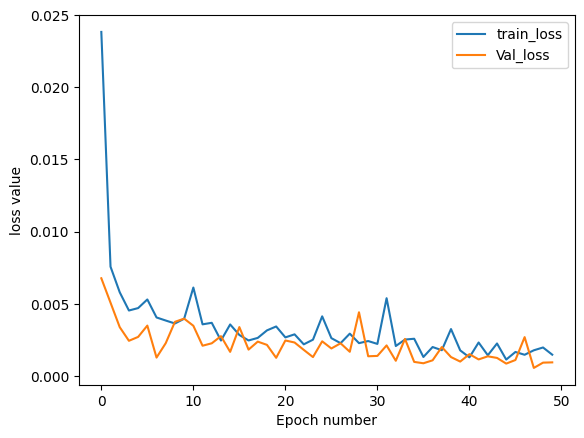

In [ ]:
# plot history
fig,ax = plt.subplots()
ax.plot(history_BiLSTM.history['loss'], label='train_loss')
ax.plot(history_BiLSTM.history['val_loss'], label='Val_loss')
ax.set_xlabel('Epoch number')
ax.set_ylabel('loss value')
ax.legend()
plt.show()

In [ ]:
BiLSTM_model = model

In [12]:
BiLSTM_model = load_model("gdrive/My Drive/GCNIDS_Improvement/BiLSTM_model.h5")

In [ ]:

BiLSTM_model.save("gdrive/My Drive/GCNIDS_Improvement/BiLSTM_model(1).h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
predictions = BiLSTM_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
# Assuming 'model' is your trained model for binary classification


7500/7500 [==============================] - 29s 4ms/step


In [ ]:
accuracy = accuracy_score(y_test, predicted_classes)
precision = precision_score(y_test, predicted_classes, average='weighted')
recall = recall_score(y_test, predicted_classes, average='weighted')
f1 = f1_score(y_test, predicted_classes, average='weighted')
print(f"Accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"f1: {f1}")
# Train BiLSTM
# Define and train your BiLSTM model using TensorFlow/Keras

Accuracy: 0.9997541656423569
precision: 0.9997541540470689
recall: 0.9997541656423569
f1: 0.9997541596346882


"Accuracy And Loss of BiLSTM and CNN"

NameError: name 'history_cnn' is not defined

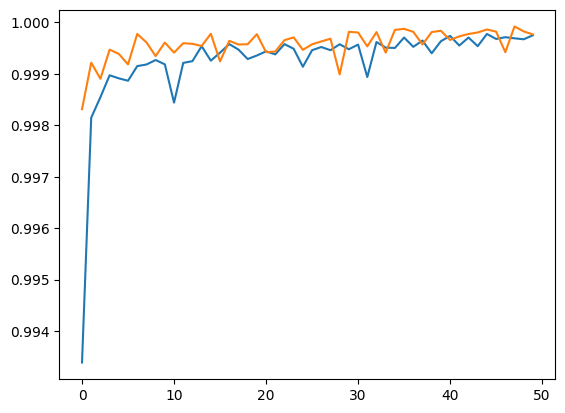

In [ ]:
# plot history
fig,ax = plt.subplots()
ax.plot(history_BiLSTM.history['accuracy'], label='train_accuracy_BiLSTM')
ax.plot(history_BiLSTM.history['val_accuracy'], label='Val_accuracy_BiLSTM')
ax.plot(history_cnn.history['accuracy'], label='train_accuracy_CNN')
ax.plot(history_cnn.history['val_accuracy'], label='val_accuracy_CNN')
ax.set_xlabel('Epoch number')
ax.set_ylabel('Accuracy value')
ax.legend()
plt.show()

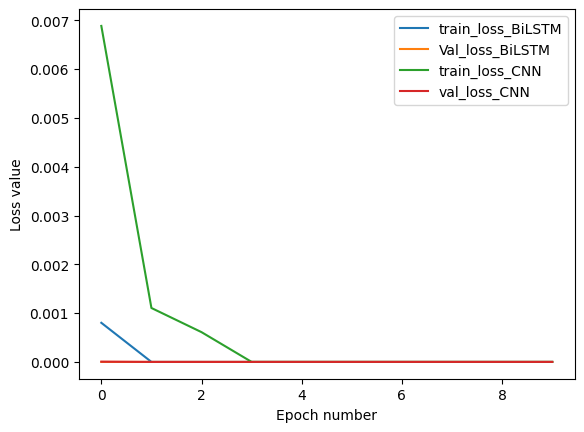

In [ ]:
# plot history
fig,ax = plt.subplots()
ax.plot(history_BiLSTM.history['loss'], label='train_loss_BiLSTM')
ax.plot(history_BiLSTM.history['val_loss'], label='Val_loss_BiLSTM')
ax.plot(history_cnn.history['loss'], label='train_loss_CNN')
ax.plot(history_cnn.history['val_loss'], label='val_loss_CNN')
ax.set_xlabel('Epoch number')
ax.set_ylabel('Loss value')
ax.legend()
plt.show()

# Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Reshape X_train if needed (if it's currently in shape (399999, 3, 2))
# X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

# Train the model
rf_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Reshape X_train if needed

# Predict on test data
predictions = rf_model.predict(X_test.reshape(X_test.shape[0], -1))  # Reshape X_test if needed

# Evaluate the model (if desired)
accuracy = rf_model.score(X_test.reshape(X_test.shape[0], -1), y_test)  # Reshape X_test if needed
print(f"Accuracy: {accuracy}")

Accuracy: 0.9999958333159722


In [13]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# Define Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)

# Define parameter distributions
param_dist = {
    'n_estimators': randint(100, 1000),   # Number of trees
    'max_depth': [None] + list(range(5, 31)),  # Maximum depth of trees
    'min_samples_split': randint(2, 11),   # Minimum samples required to split a node
    'min_samples_leaf': randint(1, 11),    # Minimum samples required at each leaf node
    'class_weight': [None, 'balanced']    # Class weight balancing
}

# Perform random search with cross-validation
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=50,
                                   cv=3, scoring='accuracy', random_state=42, n_jobs=-1)
random_search.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Print best parameters and best score
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

# Train final model using best parameters
best_rf_model = random_search.best_estimator_
best_rf_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)



KeyboardInterrupt: 

In [ ]:


# Assuming rf_model is your trained Random Forest model and predictions are made

# Accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

# Precision
precision = precision_score(y_test, predictions, average='weighted' )
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_test, predictions, average='weighted')
print(f"Recall: {recall}")

# F1-score
f1 = f1_score(y_test, predictions, average='weighted')
print(f"F1-Score: {f1}")


# Meta_Learner Model

In [24]:
# 3. Generate predictions
cnn_pred = cnn_model.predict(X_val)
cnn_preds = np.argmax(cnn_pred, axis=1)
lstm_pred = BiLSTM_model.predict(X_val)
lstm_preds = np.argmax(lstm_pred, axis=1)
rf_preds = rf_model.predict(X_val.reshape(X_val.shape[0], -1))


7500/7500 [==============================] - 24s 3ms/step


In [25]:
rf_preds = rf_preds.reshape(rf_preds.shape[0])
print (cnn_preds.shape)
print (lstm_preds.shape)
print (rf_preds.shape)


(240000,)
(240000,)
(240000,)


In [26]:
print("cnn_preds shape:", cnn_preds.shape)
print("lstm_preds shape:", lstm_preds.shape)
print("rf_preds shape:", rf_preds.shape)
print("X_val shape:", X_val.shape)

cnn_preds shape: (240000,)
lstm_preds shape: (240000,)
rf_preds shape: (240000,)
X_val shape: (240000, 3, 10)


In [27]:
# 4. Create meta-learner dataset
# Concatenate along axis 1
meta_features = np.concatenate((cnn_preds[:, np.newaxis], lstm_preds[:, np.newaxis], rf_preds[:, np.newaxis]), axis=1)
meta_dataset = np.concatenate((meta_features, X_val.reshape(X_val.shape[0], -1)), axis=1)  # Assuming features include more than just predictions


In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define logistic regression model
meta_learner = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],        # Regularization type
    'class_weight': [None, 'balanced']  # Class weight balancing
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(meta_learner, param_grid, cv=5, scoring='accuracy')
grid_search.fit(meta_dataset, y_val)

# Print best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Train final model using best parameters
best_meta_learner = grid_search.best_estimator_
best_meta_learner.fit(meta_dataset, y_val)
"""Best parameters: {'C': 0.01, 'class_weight': None, 'penalty': 'l2'"""

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best parameters: {'C': 0.01, 'class_weight': None, 'penalty': 'l2'}
Best cross-validation score: 0.9890291666666666


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.01, multi_class='multinomial')

In [30]:
# Train final model using best parameters
best_meta_learner = grid_search.best_estimator_
best_meta_learner.fit(meta_dataset, y_val)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.01, multi_class='multinomial')

# Ensemble Model

In [32]:
import multiprocessing
# 6. Ensemble prediction
start1 = ti.time()
def Ensemble1(test) :
  cnn_pred = cnn_model.predict(test)
  cnn_test_preds = np.argmax(cnn_pred, axis=1)
  lstm_pred = BiLSTM_model.predict(test)
  lstm_test_preds = np.argmax(lstm_pred, axis=1)
  rf_test_preds = rf_model.predict(test.reshape(test.shape[0], -1))
  rf_test_preds = rf_test_preds.reshape(rf_test_preds.shape[0])
  meta_test_features = np.concatenate((cnn_test_preds[:, np.newaxis], lstm_test_preds[:, np.newaxis], rf_test_preds[:, np.newaxis],  test.reshape(test.shape[0], -1)), axis=1)
  final_prediction = best_meta_learner.predict(meta_test_features)
  return final_prediction
start1 = ti.time()
final_prediction = Ensemble1 (X_test)
end1 = ti.time()

Time1 = end1 - start1

7500/7500 [==============================] - 25s 3ms/step


In [33]:
Time1

85.09459614753723

In [34]:
ytrue = y_test.tolist()
yhat = final_prediction.tolist()

In [35]:
print (final_prediction.shape)
print (y_test.shape)
print  (f"Number of attacks free massages in Actual data : {ytrue.count(0)}, Number of DoS attacks  in Actual data : {ytrue.count(1)}, Number of Fuzzy attacks in Actual data : {ytrue.count(2)}, Number of spoofing Gear attacks in Actual data : {ytrue.count(3)}, Number of Spoofing RPM attacks in Actual data : {ytrue.count(4)} ")
print  (f"Number of attacks free massages in Predicted data : {yhat.count(0)}, Number of DoS attacks  in Predicted data : {yhat.count(1)}, Number of Fuzzy attacks in Predicted data : {yhat.count(2)}, Number of spoofing Gear attacks in Predicted data : {yhat.count(3)}, Number of Spoofing RPM attacks in Predicted data : {yhat.count(4)}")

(239999,)
(239999,)
Number of attacks free massages in Actual data : 196920, Number of DoS attacks  in Actual data : 12635, Number of Fuzzy attacks in Actual data : 10052, Number of spoofing Gear attacks in Actual data : 9762, Number of Spoofing RPM attacks in Actual data : 10630 
Number of attacks free massages in Predicted data : 198610, Number of DoS attacks  in Predicted data : 12404, Number of Fuzzy attacks in Predicted data : 8562, Number of spoofing Gear attacks in Predicted data : 9785, Number of Spoofing RPM attacks in Predicted data : 10638


In [36]:
# define our Confusion matrix beased on our info
def conf(yTrue,yPred):
  tp,tn,fp,fn = 0,0,0,0
  for i in range(len(yTrue)):
    if yTrue[i] == yPred[i] and yTrue[i] == 1:
      tp= tp+1

    elif yTrue[i] == yPred[i] and yTrue[i] == 0:
      tn = tn+1
    elif yTrue[i] == 0 and yPred[i] == 1:
      fp=fp+1
    else:
      fn=fn+1


  return np.array([[tp,fp],[fn,tn]])

"""

my_conf = conf(ytrue,yhat)
print (f'TP:{my_conf[0][0]}')
print (f'FP:{my_conf[0][1]}')
print (f'FN:{my_conf[1][0]}')
print (f'TN:{my_conf[1][1]}')
"""

"\n\nmy_conf = conf(ytrue,yhat)\nprint (f'TP:{my_conf[0][0]}')\nprint (f'FP:{my_conf[0][1]}')\nprint (f'FN:{my_conf[1][0]}')\nprint (f'TN:{my_conf[1][1]}')\n"

In [37]:
# Accuracy
accuracy = accuracy_score(y_test, final_prediction)
print(f"Accuracy: {accuracy}")

# Precision
precision = precision_score(y_test, final_prediction, average='weighted')
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_test, final_prediction, average='weighted')
print(f"Recall: {recall}")

# F1-score
f1 = f1_score(y_test, final_prediction, average='weighted')
print(f"F1-Score: {f1}")


Accuracy: 0.9898416243401014
Precision: 0.9898649172304598
Recall: 0.9898416243401014
F1-Score: 0.9895865513905707


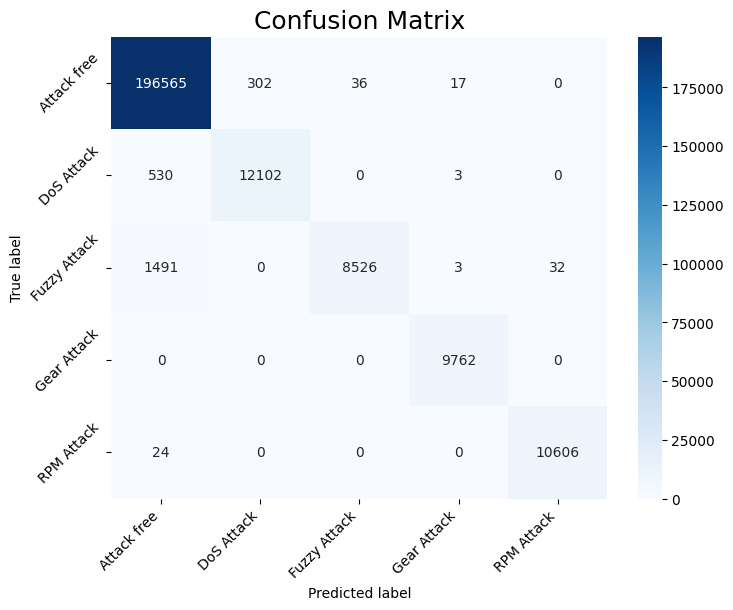

In [38]:
# Confusion matrix
import seaborn as sns
conf_matrix = confusion_matrix(y_test, final_prediction)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Attack free', 'DoS Attack', 'Fuzzy Attack', 'Gear Attack', 'RPM Attack'],
            yticklabels=['Attack free', 'DoS Attack', 'Fuzzy Attack', 'Gear Attack', 'RPM Attack'])
plt.rcParams['font.size'] = 15
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.yticks(rotation = 45)
plt.xticks(rotation = 45, ha = 'right')
plt.title('Confusion Matrix')
plt.show()